In [1]:
import torch
from models import SparseAutoencoder  # Ensure this matches the model definition you uploaded
from huggingface_hub import hf_hub_download
import einops

# Set parameters
repo_name = "charlieoneill/sparse-coding"  # Adjust this with your repo name
model_filename = "sparse_autoencoder.pth"  # Name of the model file you uploaded
input_dim = 768  # Example input dim, adjust based on your model
hidden_dim = 22 * input_dim  # Projection up parameter * input_dim

# Download the model from Hugging Face Hub
model_path = hf_hub_download(repo_id=repo_name, filename=model_filename)

# Load the model
sae = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim)
sae.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
sae.eval()  # Set the model to evaluation model

SparseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=768, out_features=16896, bias=True)
    (1): ReLU()
  )
  (decoder): Linear(in_features=16896, out_features=768, bias=True)
)

In [2]:
from sae_lens.training.session_loader import LMSparseAutoencoderSessionloader  
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

device = 'cpu'
layer = 9
l1_weight = 1e-4

# Load the transformer model and activation store
hook_point = "blocks.8.hook_resid_pre"  # Placeholder hook point
saes, _ = get_gpt2_res_jb_saes(hook_point)
sparse_autoencoder = saes[hook_point]
sparse_autoencoder.to(device)
sparse_autoencoder.cfg.device = device
sparse_autoencoder.cfg.hook_point = f"blocks.{layer}.attn.hook_z"
sparse_autoencoder.cfg.store_batch_size = 64

loader = LMSparseAutoencoderSessionloader(sparse_autoencoder.cfg)
transformer_model, _, activation_store = loader.load_sae_training_group_session()

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]
/Users/charlesoneill/miniconda3/envs/sparse-inference/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
from main import loss_fn

batch_tokens = activation_store.get_batch_tokens().to(device)
        
# Obtain activations from the transformer model
with torch.no_grad():
    _, cache = transformer_model.run_with_cache(batch_tokens)
    X = cache["resid_pre", layer]  # Shape: (batch, pos, d_model)
    X = einops.rearrange(X, "batch pos d_model -> (batch pos) d_model")
    del cache
    S_, X_ = sae(X)
    recon_loss, l1_loss, l0_loss, total_loss = loss_fn(X, X_, S_, l1_weight=l1_weight)

print(f"Reconstruction loss: {recon_loss.item()}")
print(f"L1 loss: {l1_loss.item()}")
print(f"L0 loss: {l0_loss.item()}")

Reconstruction loss: 0.056356366723775864
L1 loss: 261.2139892578125
L0 loss: 38.2880859375


In [5]:
from transformer_lens import HookedTransformer, utils
from datasets import load_dataset

model = HookedTransformer.from_pretrained('gpt2-small')

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800 * 8)##8)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])
owt_tokens_torch = torch.tensor(owt_tokens)

Loaded pretrained model gpt2-small into HookedTransformer


Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [7]:
from tqdm.auto import tqdm
from transformer_lens.utils import to_numpy

scores = []
endoftext_token = model.tokenizer.eos_token
batch_size = 64

feature_indices = [  0,   8,  15,  25,  32,  37,  39,  43,  50,  51,  55,  61,  63,
        65,  70,  74,  81,  93,  94,  97, 112, 117, 118, 119, 120, 122,
       128, 130, 139, 150, 152, 153, 154, 156, 163, 172, 173, 177, 183,
       191, 202, 206, 207, 215, 216, 218, 224, 229, 243, 260, 264, 273,
       275, 284, 287, 293, 297, 298, 299, 301, 302, 306, 308, 309, 325,
       330, 332, 335, 337, 338, 345, 347, 354, 356, 358, 370, 371, 373,
       381, 384, 389, 402, 413, 417, 420, 421, 426, 436, 438, 449, 451,
       453, 456, 462, 463, 464, 465, 467, 472, 481, 485, 488, 492, 509,
       513, 517, 524, 527, 538, 541, 548, 552, 560, 563, 566, 568, 573,
       575, 577, 579, 581, 582, 585, 587, 590, 594, 596, 603, 605, 621,
       624, 626, 628, 634, 636, 638, 639, 650, 656, 657, 669, 676, 677,
       687, 688, 693, 699, 709, 712, 715, 718, 728, 730, 738, 742, 743,
       751, 766, 772, 774, 776, 778, 781, 782, 786, 787, 789, 794, 796,
       797, 798, 802, 805, 808, 810, 821, 822, 823, 828, 829, 845, 851,
       864, 873, 874, 878, 879, 881, 898, 907, 908, 917, 924, 926, 930,
       931, 933, 936, 938, 953, 954, 975, 981, 983, 987, 988, 996]

for i in tqdm(range(0, owt_tokens_torch.shape[0], batch_size)):
    with torch.no_grad():
        _, cache = model.run_with_cache(
            owt_tokens_torch[i : i + batch_size],
            stop_at_layer=layer + 1,
            names_filter=None,
        )
        X = cache["resid_pre", layer].cpu()  # Shape: (batch, pos, d_model)
        X = einops.rearrange(X, "batch pos d_model -> (batch pos) d_model")
        del cache
        cur_scores = sae.encoder(X)[:, feature_indices]

    cur_scores_reshaped = to_numpy(
                                einops.rearrange(cur_scores, "(b pos) n -> b n pos", pos=owt_tokens_torch.shape[1])
                            ).astype(np.float16)
    
    scores.append(cur_scores_reshaped)

scores = np.concatenate(scores, axis=0)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [8]:
scores.shape#, flat_scores.shape

(102400, 207, 128)

In [9]:
scores_sum = scores.sum(axis=0)
scores_sum = scores_sum.sum(axis=1)

In [10]:
# Print how many are non-zero  
print(f"Number of non-zero activations: {np.count_nonzero(scores_sum)}")

# Print indices of non-zero activations
non_zero_indices = np.nonzero(scores_sum)
# Add 10000 to the indices to get the actual token indices
# non_zero_indices = non_zero_indices[0] + 10_000
print(f"Indices of non-zero activations: {non_zero_indices}")

Number of non-zero activations: 207
Indices of non-zero activations: (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,

Non-zero activations:
16,  24, 131, 420, 486, 520, 638, 651, 755, 901, 1067 1170 1350 1564 1571 1582 1805 2018 2115 2291 2310 3247 3709 3847
 3915 4947 5228 5240 5253 5653 5940 6294 6391 6645 6705 6756 6880 6995
 7075 7705 7867 7947 8134 8246 8380 8424 8734 9064 9125 9328 9659 9863
 10008 10074 10089 10443 10751 10808 10910 11041 11057 11194 11330 11543
 11594 11831 11902 12423 12424 13106 13155 13680 13897 13967 14203 14265
 14309 14589 14881 15013 15131 15487 15492 15622 15720 15903 16271 16276
 16664 16794

In [11]:
# Save scores as a numpy array of float16
np.save("scores.npy", scores)

# Autointerpretability

In [155]:
#!/usr/bin/env python3
"""
Script to analyze sparse autoencoder features by retrieving top-k activating examples,
obtaining top-k and bottom-k boosted logits, formatting prompts, and getting responses
from an AI interpreter.

Requirements:
- torch
- huggingface_hub
- einops
- numpy
- yaml
- transformer_lens
- datasets
- tqdm
- openai
- IPython
"""

import torch
from models import SparseAutoencoder  # Ensure this matches your model definition
from huggingface_hub import hf_hub_download
import einops
import numpy as np
import yaml
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from datasets import load_dataset
from openai import OpenAI, AzureOpenAI
import re
import html
from IPython.display import HTML, display

# ----------------------------- Configuration -----------------------------

# Parameters
REPO_NAME = "charlieoneill/sparse-coding"  # Hugging Face repo name
MODEL_FILENAME = "sparse_autoencoder.pth"  # Model file name in the repo
INPUT_DIM = 768  # Example input dimension
HIDDEN_DIM = 22 * INPUT_DIM  # Projection up parameter * input_dim
SCORES_PATH = "scores.npy"  # Path to the saved scores
FEATURE_INDICES = [  0,   8,  15,  25,  32,  37,  39,  43,  50,  51,  55,  61,  63,
        65,  70,  74,  81,  93,  94,  97, 112, 117, 118, 119, 120, 122,
       128, 130, 139, 150, 152, 153, 154, 156, 163, 172, 173, 177, 183,
       191, 202, 206, 207, 215, 216, 218, 224, 229, 243, 260, 264, 273,
       275, 284, 287, 293, 297, 298, 299, 301, 302, 306, 308, 309, 325,
       330, 332, 335, 337, 338, 345, 347, 354, 356, 358, 370, 371, 373,
       381, 384, 389, 402, 413, 417, 420, 421, 426, 436, 438, 449, 451,
       453, 456, 462, 463, 464, 465, 467, 472, 481, 485, 488, 492, 509,
       513, 517, 524, 527, 538, 541, 548, 552, 560, 563, 566, 568, 573,
       575, 577, 579, 581, 582, 585, 587, 590, 594, 596, 603, 605, 621,
       624, 626, 628, 634, 636, 638, 639, 650, 656, 657, 669, 676, 677,
       687, 688, 693, 699, 709, 712, 715, 718, 728, 730, 738, 742, 743,
       751, 766, 772, 774, 776, 778, 781, 782, 786, 787, 789, 794, 796,
       797, 798, 802, 805, 808, 810, 821, 822, 823, 828, 829, 845, 851,
       864, 873, 874, 878, 879, 881, 898, 907, 908, 917, 924, 926, 930,
       931, 933, 936, 938, 953, 954, 975, 981, 983, 987, 988, 996]
feature_indices = FEATURE_INDICES
TOP_K = 10  # Number of top activating examples
BOTTOM_K = 10  # Number of bottom boosted logits

# OpenAI Configuration
CONFIG_PATH = "config.yaml"  # Path to your config file containing API keys

# ----------------------------- Helper Functions -----------------------------

def load_sparse_autoencoder(repo_name: str, model_filename: str, input_dim: int, hidden_dim: int) -> SparseAutoencoder:
    model_path = hf_hub_download(repo_id=repo_name, filename=model_filename)
    sae = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim)
    sae.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    sae.eval()
    return sae

def load_transformer_model(model_name: str = 'gpt2-small') -> HookedTransformer:
    model = HookedTransformer.from_pretrained(model_name)
    return model.cpu()

def load_scores(scores_path: str) -> np.ndarray:
    scores = np.load(scores_path)
    return scores

def load_tokenized_data(max_length: int = 128, batch_size: int = 64, take_size: int = 102400) -> torch.Tensor:
    def tokenize_and_concatenate(
        dataset,
        tokenizer,
        streaming=False,
        max_length=1024,
        column_name="text",
        add_bos_token=True,
    ):
        for key in dataset.features:
            if key != column_name:
                dataset = dataset.remove_columns(key)
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": "<PAD>"})
        seq_len = max_length - 1 if add_bos_token else max_length

        def tokenize_function(examples):
            text = examples[column_name]
            full_text = tokenizer.eos_token.join(text)
            num_chunks = 20
            chunk_length = (len(full_text) - 1) // num_chunks + 1
            chunks = [
                full_text[i * chunk_length : (i + 1) * chunk_length]
                for i in range(num_chunks)
            ]
            tokens = tokenizer(chunks, return_tensors="np", padding=True)[
                "input_ids"
            ].flatten()
            tokens = tokens[tokens != tokenizer.pad_token_id]
            num_tokens = len(tokens)
            num_batches = num_tokens // seq_len
            tokens = tokens[: seq_len * num_batches]
            tokens = einops.rearrange(
                tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
            )
            if add_bos_token:
                prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
                tokens = np.concatenate([prefix, tokens], axis=1)
            return {"tokens": tokens}

        tokenized_dataset = dataset.map(
            tokenize_function, batched=True, remove_columns=[column_name]
        )
        return tokenized_dataset

    transformer_model = load_transformer_model()
    dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
    dataset = dataset.shuffle(seed=42, buffer_size=10_000)
    tokenized_owt = tokenize_and_concatenate(dataset, transformer_model.tokenizer, max_length=max_length, streaming=True)
    tokenized_owt = tokenized_owt.shuffle(42)
    tokenized_owt = tokenized_owt.take(take_size)
    owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])
    owt_tokens_torch = torch.tensor(owt_tokens)
    return owt_tokens_torch

def compute_scores(sae: SparseAutoencoder, transformer_model: HookedTransformer, owt_tokens_torch: torch.Tensor, layer: int, feature_indices: list, device: str = 'cpu') -> np.ndarray:
    sae.eval()

    # Compute scores
    scores = []
    batch_size = 64
    for i in tqdm(range(0, owt_tokens_torch.shape[0], batch_size), desc="Computing scores"):
        with torch.no_grad():
            _, cache = transformer_model.run_with_cache(
                owt_tokens_torch[i : i + batch_size],
                stop_at_layer=layer + 1,
                names_filter=None,
            )
            X = cache["resid_pre", layer].cpu()  # Shape: (batch, pos, d_model)
            X = einops.rearrange(X, "batch pos d_model -> (batch pos) d_model")
            del cache
            cur_scores = sae.encoder(X)[:, feature_indices]
            cur_scores_reshaped = einops.rearrange(cur_scores, "(b pos) n -> b n pos", pos=owt_tokens_torch.shape[1]).cpu().numpy().astype(np.float16)
            scores.append(cur_scores_reshaped)

    scores = np.concatenate(scores, axis=0)
    np.save(SCORES_PATH, scores)
    return scores

def get_top_k_indices(scores: np.ndarray, feature_index: int, k: int = TOP_K) -> np.ndarray:
    """ 
    Get the indices of the examples where the feature activates the most
    scores is shape (batch, feature, pos), so we index with feature_index
    """
    feature_scores = scores[:, feature_index, :]
    top_k_indices = feature_scores.argsort()[-k:][::-1]
    return top_k_indices

def get_topk_bottomk_logits(feature_index: int, sae: SparseAutoencoder, transformer_model: HookedTransformer, k: int = TOP_K) -> tuple:
    feature_vector = sae.decoder.weight.data[:, feature_index]
    W_U = transformer_model.W_U  # (d_model, vocab)
    logits = einops.einsum(W_U, feature_vector, "d_model vocab, d_model -> vocab")
    top_k_logits = logits.topk(k).indices
    bottom_k_logits = logits.topk(k, largest=False).indices
    top_k_tokens = [transformer_model.to_string(x.item()) for x in top_k_logits]
    bottom_k_tokens = [transformer_model.to_string(x.item()) for x in bottom_k_logits]
    return top_k_tokens, bottom_k_tokens

def highlight_scores_in_html(token_strs: list, scores: list, seq_idx: int, max_color: str = "#ff8c00", zero_color: str = "#ffffff", show_score: bool = True) -> tuple:
    if len(token_strs) != len(scores):
        print(f"Length mismatch between tokens and scores (len(tokens)={len(token_strs)}, len(scores)={len(scores)})") 
        return "", ""
    scores_min = min(scores)
    scores_max = max(scores)
    if scores_max - scores_min == 0:
        scores_normalized = np.zeros_like(scores)
    else:
        scores_normalized = (np.array(scores) - scores_min) / (scores_max - scores_min)
    max_color_vec = np.array(
        [int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)]
    )
    zero_color_vec = np.array(
        [int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)]
    )
    color_vecs = np.einsum("i, j -> ij", scores_normalized, max_color_vec) + np.einsum(
        "i, j -> ij", 1 - scores_normalized, zero_color_vec
    )
    color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]
    if show_score:
        tokens_html = "".join(
            [
                f"""<span class='token' style='background-color: {color_strs[i]}'>{html.escape(token_str)}<span class='feature_val'> ({scores[i]:.2f})</span></span>"""
                for i, token_str in enumerate(token_strs)
            ]
        )
        clean_text = " | ".join(
            [f"{token_str} ({scores[i]:.2f})" for i, token_str in enumerate(token_strs)]
        )
    else:
        tokens_html = "".join(
            [
                f"""<span class='token' style='background-color: {color_strs[i]}'>{html.escape(token_str)}</span>"""
                for i, token_str in enumerate(token_strs)
            ]
        )
        clean_text = " | ".join(token_strs)
    head = """
    <style>
        span.token {
            font-family: monospace;
            border-style: solid;
            border-width: 1px;
            border-color: #dddddd;
        }
        span.feature_val {
            font-size: smaller;
            color: #555555;
        }
    </style>
    """
    return head + tokens_html, convert_clean_text(clean_text)

def convert_clean_text(clean_text: str, k: int = 1, tokens_left: int = 30, tokens_right: int = 5) -> str:
    # Split the clean text on the "|" separator
    token_score_pairs = clean_text.split(" | ")

    # Remove the first token if present
    if token_score_pairs:
        token_score_pairs = token_score_pairs[1:]

    # Initialize a list to hold tuples of (token, score)
    tokens_with_scores = []

    # Define regex to capture tokens with scores
    token_score_pattern = re.compile(r"^(.+?) \((\d+\.\d+)\)$")

    for token_score in token_score_pairs:
        match = token_score_pattern.match(token_score.strip())
        if match:
            token = match.group(1)
            score = float(match.group(2))
            tokens_with_scores.append((token, score))
        else:
            # Handle cases where score is zero or absent
            token = token_score.split(' (')[0].strip()
            tokens_with_scores.append((token, 0.0))

    # Sort tokens by score in descending order
    sorted_tokens = sorted(tokens_with_scores, key=lambda x: x[1], reverse=True)

    # Select top k tokens with non-zero scores
    top_k_tokens = [token for token, score in sorted_tokens if score > 0][:k]

    # Find all indices of top k tokens
    top_k_indices = [i for i, (token, score) in enumerate(tokens_with_scores) if token in top_k_tokens and score >0]

    # Define windows around each top token
    windows = []
    for idx in top_k_indices:
        start = max(0, idx - tokens_left)
        end = min(len(tokens_with_scores) - 1, idx + tokens_right)
        windows.append((start, end))

    # Merge overlapping windows
    merged_windows = []
    for window in sorted(windows, key=lambda x: x[0]):
        if not merged_windows:
            merged_windows.append(window)
        else:
            last_start, last_end = merged_windows[-1]
            current_start, current_end = window
            if current_start <= last_end + 1:
                # Overlapping or adjacent windows, merge them
                merged_windows[-1] = (last_start, max(last_end, current_end))
            else:
                merged_windows.append(window)

    # Collect all unique indices within the merged windows
    selected_indices = set()
    for start, end in merged_windows:
        selected_indices.update(range(start, end + 1))

    # Create the converted tokens list with wrapping
    converted_tokens = []
    for i, (token, score) in enumerate(tokens_with_scores):
        if i in selected_indices:
            if token in top_k_tokens and score > 0:
                token = f"<<{token}>>"
            converted_tokens.append(token)
        # Else, skip tokens outside the selected windows

    # Join the converted tokens into a single string
    converted_text = " ".join(converted_tokens)
    return converted_text

def format_interpreter_prompt(clean_text: str, top_k_tokens: list, bottom_k_tokens: list) -> str:
    system_prompt = """### SYSTEM PROMPT ###

You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior.
Guidelines:

You will be given a list of text examples on which the neuron activates. The specific tokens which cause the neuron to activate will appear between delimiters like <<this>>. If a sequence of consecutive tokens all cause the neuron to activate, the entire sequence of tokens will be contained between delimiters <<just like this>>. The activation value of the example is listed after each example in parentheses.

- Try to produce a concise final description. Simply describe the text features that activate the neuron, and what its role might be based on the tokens it predicts.
- If either the text features or the predicted tokens are completely uninformative, you don't need to mention them.
- The last line of your response must be the formatted explanation."""

    cot_prompt = """
(Part 1) Tokens that the neuron activates highly on in text

Step 1: List a couple activating and contextual tokens you find interesting. Search for patterns in these tokens, if there are any. Don't list more than 5 tokens.
Step 2: Write down general shared features of the text examples.
"""

    activations_section = """
(Part 1) Tokens that the neuron activates highly on in text

Step 1: List a couple activating and contextual tokens you find interesting. Search for patterns in these tokens, if there are any.
Step 2: Write down several general shared features of the text examples.
Step 3: Take note of the activation values to understand which examples are most representative of the neuron.
"""

    logits_section = """
(Part 2) Tokens that the neuron boosts in the next token prediction

You will also be shown a list called Top_logits. The logits promoted by the neuron shed light on how the neuron's activation influences the model's predictions or outputs. Look at this list of Top_logits and refine your hypotheses from part 1. It is possible that this list is more informative than the examples from part 1.

Pay close attention to the words in this list and write down what they have in common. Then look at what they have in common, as well as patterns in the tokens you found in Part 1, to produce a single explanation for what features of text cause the neuron to activate. Propose your explanation in the following format:
[EXPLANATION]: <your explanation>
"""

    # Define the Examples and Their Responses (can be customized or loaded from a file)
    examples = """
### EXAMPLE STEP-BY-STEP WALKTHROUGH 1 ###
Example 1:  and he was <<over the moon>> to find
Example 2:  we'll be laughing <<till the cows come home>>! Pro
Example 3:  thought Scotland was boring, but really there's more <<than meets the eye>>! I'd

Top_logits: ["elated", "joyful", "story", "thrilled", "spider"]

(Part 1)
ACTIVATING TOKENS: "over the moon", "than meets the eye".
PREVIOUS TOKENS: No interesting patterns.

Step 1.
The activating tokens are all parts of common idioms.
The previous tokens have nothing in common.

Step 2.
- The examples contain common idioms.
- In some examples, the activating tokens are followed by an exclamation mark.

Let me think carefully. Did I miss any patterns in the text examples? Are there any more linguistic similarities?
- Yes, I missed one: The text examples all convey positive sentiment.

(Part 2)
SIMILAR TOKENS: "elated", "joyful", "thrilled".
- The top logits list contains words that are strongly associated with positive emotions.

[EXPLANATION]: Common idioms in text conveying positive sentiment.

### EXAMPLE STEP-BY-STEP WALKTHROUGH 2 ###

Example 1:  a river is wide but the ocean is wid<<er>>. The ocean
Example 2:  every year you get tall<<er>>," she
Example 3:  the hole was small<<er>> but deep<<er>> than the

Top_logits: ["apple", "running", "book", "wider", "quickly"]

(Part 1)
ACTIVATING TOKENS: "er", "er", "er".
PREVIOUS TOKENS: "wid", "tall", "small", "deep".

Step 1.
- The activating tokens are mostly "er".
- The previous tokens are mostly adjectives, or parts of adjectives, describing size.
- The neuron seems to activate on, or near, the tokens in comparative adjectives describing size.

Step 2.
- In each example, the activating token appeared at the end of a comparative adjective.
- The comparative adjectives ("wider", "tallish", "smaller", "deeper") all describe size.

Let me look again for patterns in the examples. Are there any links or hidden linguistic commonalities that I missed?
- I can't see any.

(Part 2)
SIMILAR TOKENS: None
- The top logits list contains unrelated nouns and adverbs.

[EXPLANATION]: The token "er" at the end of a comparative adjective describing size.

### EXAMPLE STEP-BY-STEP WALKTHROUGH 3 ###

Example 1:  something happening inside my <<house>>", he
Example 2:  presumably was always contained in <<a box>>", according
Example 3:  people were coming into the <<smoking area>>".

However he
Example 4:  Patrick: "why are you getting in the << way?>>" Later,

Top_logits: ["room", "end", "container", "space", "plane"]

(Part 1)
ACTIVATING TOKENS: "house", "a box", "smoking area", "way?".
PREVIOUS TOKENS: No interesting patterns.

Step 1.
- The activating tokens are all things that one can be in.
- The previous tokens have nothing in common.

Step 2.
- The examples involve being inside something, sometimes figuratively.
- The activating token is a thing which something else is inside of.

Let me think carefully. Did I miss any patterns in the text examples? Are there any more linguistic similarities?
- Yes, I missed one: The activating token is followed by a quotation mark, suggesting it occurs within speech.

(Part 2)
SIMILAR TOKENS: "room", "container", "space".
- The top logits list suggests a focus on nouns representing physical or metaphorical spaces.

[EXPLANATION]: Nouns preceding a quotation mark, representing distinct objects that contain something.
"""

    # Combine all predefined sections
    predefined_prompt = f"""{system_prompt}

{cot_prompt}

{logits_section}

We will now provide three step-by-step examples of how you should approach this.

{examples}
"""

    # Prepare the current data sections
    # Format the top_k_tokens and bottom_k_tokens as JSON-like lists
    top_logits_str = "[" + ", ".join(f'"{token}"' for token in top_k_tokens) + "]"
    bottom_logits_str = "[" + ", ".join(f'"{token}"' for token in bottom_k_tokens) + "]"

    current_activations = f"""
(Part 1) Tokens that the neuron activates highly on in text

{clean_text}
"""

    current_logits = f"""
(Part 2) Tokens that the neuron boosts in the next token prediction

Top_logits: {top_logits_str}
Bottom_logits: {bottom_logits_str}
"""

    # Combine all parts into the final prompt
    full_prompt = f"""{predefined_prompt}

### OUR NEURON WE NEED TO INTERPRET STEP-BY-STEP ###

{current_activations}

{current_logits}

Walk through the steps to interpret this neuron.
"""
    return full_prompt

def get_ai_response(formatted_prompt: str, config: dict) -> str:
    azure_client = AzureOpenAI(
        azure_endpoint=config["base_url"],
        api_key=config["azure_api_key"],
        api_version=config["api_version"],
    )
    
    # If prompt is a str
    if type(formatted_prompt) == str:
        messages = [{"role": "user", "content": formatted_prompt}]
    elif type(formatted_prompt) == list:
        messages = formatted_prompt
    response = azure_client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
    )
    return response.choices[0].message.content

# ----------------------------- Main Processing Function -----------------------------

def analyze_feature(feature_index: int, sae: SparseAutoencoder, transformer_model: HookedTransformer, 
                   owt_tokens_torch: torch.Tensor, scores: np.ndarray, top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq,
                   config: dict, 
                   top_k: int = TOP_K, bottom_k: int = BOTTOM_K) -> None:
    """ 
    Returns formatted_prompt, analysis, interp_text, scoring_text, false_text
    """

    
    # Get top-k and bottom-k boosted logits
    top_logits, bottom_logits = get_topk_bottomk_logits(feature_indices[feature_index], sae, transformer_model, k=top_k)
    
    # Highlight scores in HTML and prepare clean text
    examples_html = []
    examples_clean_text = []
    examples_false_text = []

    # False feature index
    false_feature_idx = 0 if feature_index != 0 else 15

    # Single-feature slice: (batch, seq_len)
    single_feature_scores_false = scores[:, false_feature_idx, :]  

    # Flatten, pick top k
    flat_scores_false = single_feature_scores_false.flatten()
    top_k_indices_false = flat_scores_false.argsort()[-top_k:][::-1]
    top_k_batch_indices_false, top_k_seq_indices_false = np.unravel_index(
        top_k_indices_false, single_feature_scores_false.shape
    )
    top_k_tokens_false = [owt_tokens_torch[b].tolist() for b in top_k_batch_indices_false]
    top_k_tokens_str_false = [
        [transformer_model.to_string(tok_id) for tok_id in seq]
        for seq in top_k_tokens_false
    ]
    top_k_scores_per_seq_false = [scores[b] for b in top_k_batch_indices_false]

    for i in range(top_k):
        try:
            example_html, clean_text = highlight_scores_in_html(
                top_k_tokens_str[i],
                top_k_scores_per_seq[i][feature_index],
                seq_idx=i,
                show_score=True
            )
            _, false_text = highlight_scores_in_html(
                top_k_tokens_str_false[i],
                top_k_scores_per_seq_false[i][false_feature_idx],
                seq_idx=i,
                show_score=True
            )
            examples_html.append(example_html)
            if len(clean_text) > 10:
                #print(f'Length of clean text: {len(clean_text)}')
                examples_clean_text.append(clean_text)
                examples_false_text.append(false_text)
        except Exception as e:
            print(f"Error processing example {i}: {e}")
            continue


    # If length of examples_clean_text is less than top_k, raise an exception
    if len(examples_clean_text) < 4:
        raise Exception(f"Not enough activating examples (number of examples: {len(examples_clean_text)})")

    
    # Combine clean texts
    length_examples = len(examples_clean_text) // 2
    examples_to_insert = [f"Example {i+1}: {example}" for i, example in enumerate(examples_clean_text)][:length_examples]
    combined_clean_text = "\n\n".join(examples_to_insert).strip()

    if len(combined_clean_text) < 100:
        raise Exception("No activating examples for this one")
    
    # Format the prompt
    formatted_prompt = format_interpreter_prompt(combined_clean_text, top_logits, bottom_logits)
    
    # Get the AI response
    analysis = get_ai_response(formatted_prompt, config)

    interp_text = examples_clean_text[:length_examples]
    scoring_text = examples_clean_text[length_examples:length_examples*2]
    false_text = examples_false_text[:length_examples]

    return formatted_prompt, analysis, interp_text, scoring_text, false_text

In [30]:
"""
Main function to execute the analysis for all defined feature indices.
"""
# Load configuration
config = yaml.safe_load(open(CONFIG_PATH))

# Load models
sae = load_sparse_autoencoder(REPO_NAME, MODEL_FILENAME, INPUT_DIM, HIDDEN_DIM)
transformer_model = load_transformer_model()

# Load or compute scores
try:
    scores = load_scores(SCORES_PATH)
except FileNotFoundError:
    print(f"Scores file not found at {SCORES_PATH}. Computing scores...")
    owt_tokens_torch = load_tokenized_data()
    # Assume layer and loss_fn are defined appropriately
    layer = 9  # Example layer
    device = 'cpu'
    scores = compute_scores(sae, transformer_model, owt_tokens_torch, layer, FEATURE_INDICES, device=device)

# Load tokenized data
owt_tokens_torch = load_tokenized_data()

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu
Scores file not found at scores.npy. Computing scores...
Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


Computing scores:   0%|          | 0/1600 [00:00<?, ?it/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [32]:
# 1) Count number of non-zero entries
nonzero_count = np.count_nonzero(scores)

# 2) Number of features with any non-zero activation
features_nonzero = np.sum((scores != 0).any(axis=(0, 2)))

# 3) Mean number of examples an activating feature activates on
#    For each feature, count how many examples are non-zero (anywhere along the last axis).
examples_per_feature = np.sum((scores != 0).any(axis=2), axis=0)
mean_examples = np.mean(examples_per_feature[examples_per_feature > 0])

print("Number of non-zero entries:", nonzero_count)
print("Number of features with non-zero activations:", features_nonzero)
print("Mean number of examples an activating feature activates on:", mean_examples)

Number of non-zero entries: 25442071
Number of features with non-zero activations: 207
Mean number of examples an activating feature activates on: 2529.207729468599


In [89]:
def format_score_prompt(interpretation, examples, false_examples):
    DSCORER_SYSTEM_PROMPT = """You are an intelligent and meticulous linguistics researcher.

    You will be given a certain feature of text, such as "male pronouns" or "text with negative sentiment". You will be given a few examples of text that contain this feature. Portions of the sentence which strongly represent this feature are between tokens << and >>.

    Some examples might be mislabeled. Your task is to determine if every single token within << and >> is correctly labeled. Consider that all provided examples could be correct, none of the examples could be correct, or a mix. An example is only correct if every marked token is representative of the feature

    For each example in turn, return 1 if the sentence is correctly labeled or 0 if the tokens are mislabeled. You must return your response in a valid Python list. Do not return anything else besides a Python list.
    """

    # https://www.neuronpedia.org/gpt2-small/6-res-jb/6048
    DSCORER_EXAMPLE_ONE = """Feature explanation: Words related to American football positions, specifically the tight end position.

    Text examples:

    Example 0:<|endoftext|>Getty ImagesĊĊPatriots<< tight end>> Rob Gronkowski had his bossâĢĻ
    Example 1: posted<|endoftext|>You should know this<< about>> offensive line coaches: they are large, demanding<< men>>
    Example 2: Media Day 2015ĊĊLSU<< defensive>> end Isaiah Washington (94) speaks<< to the>>
    Example 3:<< running backs>>," he said. .. Defensive<< end>> Carroll Phillips is improving and his injury is
    Example 4:<< line>>, with the left side âĢĶ namely<< tackle>> Byron Bell at<< tackle>> and<< guard>> Amini
    """

    DSCORER_RESPONSE_ONE = "[1,0,0,1,1]"

    # https://www.neuronpedia.org/gpt2-small/6-res-jb/9396
    DSCORER_EXAMPLE_TWO = """Feature explanation: The word "guys" in the phrase "you guys".

    Text examples:

    Example 0: if you are<< comfortable>> with it. You<< guys>> support me in many other ways already and
    Example 1: birth control access<|endoftext|> but I assure you<< women>> in Kentucky aren't laughing as they struggle
    Example 2:âĢĻs gig! I hope you guys<< LOVE>> her, and<< please>> be nice,
    Example 3:American, told<< Hannity>> that âĢľyou<< guys>> are playing the race card.âĢĿ
    Example 4:<< the>><|endoftext|>ľI want to<< remind>> you all that 10 days ago (director Massimil
    """

    DSCORER_RESPONSE_TWO = "[0,0,0,0,0]"

    # https://www.neuronpedia.org/gpt2-small/8-res-jb/12654
    DSCORER_EXAMPLE_THREE = """Feature explanation: "of" before words that start with a capital letter.

    Text examples:

    Example 0: climate, TomblinâĢĻs Chief<< of>> Staff Charlie Lorensen said.Ċ
    Example 1: no wonderworking relics, no true Body and Blood<< of>> Christ, no true Baptism
    Example 2:ĊĊDeborah Sathe, Head<< of>> Talent Development and Production at Film London,
    Example 3:ĊĊIt has been devised by Director<< of>> Public Prosecutions (DPP)
    Example 4: and fair investigation not even include the Director<< of>> Athletics? Â· Finally, we believe the
    """

    DSCORER_RESPONSE_THREE = "[1,1,1,1,1]"
    combined_examples = examples + false_examples
    examples_to_insert = [f"Example {i+1}: {example}" for i, example in enumerate(combined_examples)]
    combined_clean_text = "\n\n".join(examples_to_insert).strip()
    

    GENERATION_PROMPT = f"""Feature explanation: {interpretation}

    Text examples:

    {combined_clean_text}
    """

    final_user_prompt = f"""

    ### EXAMPLE 1 ###
    {DSCORER_EXAMPLE_ONE}
    {DSCORER_RESPONSE_ONE}

    ### EXAMPLE 2 ###
    {DSCORER_EXAMPLE_TWO}
    {DSCORER_RESPONSE_TWO}

    ### EXAMPLE 3 ###
    {DSCORER_EXAMPLE_THREE}
    {DSCORER_RESPONSE_THREE}

    ### YOUR TURN ###
    {GENERATION_PROMPT}
    """

    return [{"role": "system", "content": DSCORER_SYSTEM_PROMPT}, {"role": "user", "content": final_user_prompt}]


# interpretation = "Adjectives conveying positive attributes or strong characteristics."
# prompt = format_score_prompt(interpretation=interpretation, examples=scoring_text, false_examples=false_text)

In [137]:
from sklearn.metrics import f1_score

def calculate_f1_score(scoring_response, scoring_text, false_text):

    # print(f"Scoring response: {scoring_response}")

    # Get response from string
    scoring_response = eval('['+scoring_response.split('[')[-1].split(']')[0]+']')
    #print(f"Scoring response: {scoring_response}")

    y_ones = np.ones(len(scoring_text))
    y_zeros = np.zeros(len(false_text))
    y_true = np.concatenate([y_ones, y_zeros])
    y_pred = np.array(scoring_response)
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

# calculate_f1_score(response, scoring_text, false_text)

In [153]:
f_idx = 1
#print(f"Analyzing feature {f_idx} (feature id = {feat_id})...")
# Single-feature slice: (batch, seq_len)
single_feature_scores = scores[:, f_idx, :]  

# Flatten, pick top k
flat_scores = single_feature_scores.flatten()
top_k_indices = flat_scores.argsort()[-k:][::-1]
top_k_batch_indices, top_k_seq_indices = np.unravel_index(
    top_k_indices, single_feature_scores.shape
)

# Convert to tokens
top_k_tokens = [owt_tokens_torch[b].tolist() for b in top_k_batch_indices]
top_k_tokens_str = [
    [transformer_model.to_string(tok_id) for tok_id in seq]
    for seq in top_k_tokens
]

# Collect entire (n_features, seq_len) so we can index [feature_index] → (seq_len,)
top_k_scores_per_seq = [scores[b] for b in top_k_batch_indices]
#   ^ scores[b].shape = (n_features, seq_len)
#     so top_k_scores_per_seq[i][f_idx] is shape (seq_len,)

# Now call analyze_feature on this single feature

formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(
    feature_index=f_idx,
    sae=sae,
    transformer_model=transformer_model,
    owt_tokens_torch=owt_tokens_torch,
    scores=scores,  # can still pass the full scores if needed
    top_k_indices=top_k_indices,
    top_k_batch_indices=top_k_batch_indices,
    top_k_tokens=top_k_tokens,
    top_k_tokens_str=top_k_tokens_str,
    top_k_scores_per_seq=top_k_scores_per_seq,
    config=config,
    top_k=10
)
#print(f"Feature {f_idx}: {len(interp_text)} examples for interpretation, {len(scoring_text)} for scoring, {len(false_text)} for false")
# Assert the number of non-empty strings in each list is the same
interp_length = len([x for x in interp_text if len(x) > 1])


interpretation = analysis.split("[EXPLANATION]: ")[-1]
scoring_prompt = format_score_prompt(interpretation=interpretation, examples=scoring_text, false_examples=false_text)
# for p in scoring_prompt:
#     print(p['content'])
# print()
scoring_response = get_ai_response(scoring_prompt, config)
f1 = calculate_f1_score(scoring_response, scoring_text, false_text)

print(f"F1 score for feature {f_idx}: {f1}")

F1 score for feature 1: 0.8285714285714285


In [157]:
k = 10
interp_results = []

for f_idx, feat_id in tqdm(enumerate(feature_indices), total=len(feature_indices)):
    #print(f"Analyzing feature {f_idx} (feature id = {feat_id})...")
    # Single-feature slice: (batch, seq_len)
    single_feature_scores = scores[:, f_idx, :]  

    # Flatten, pick top k
    flat_scores = single_feature_scores.flatten()
    top_k_indices = flat_scores.argsort()[-k:][::-1]
    top_k_batch_indices, top_k_seq_indices = np.unravel_index(
        top_k_indices, single_feature_scores.shape
    )

    # Convert to tokens
    top_k_tokens = [owt_tokens_torch[b].tolist() for b in top_k_batch_indices]
    top_k_tokens_str = [
        [transformer_model.to_string(tok_id) for tok_id in seq]
        for seq in top_k_tokens
    ]

    # Collect entire (n_features, seq_len) so we can index [feature_index] → (seq_len,)
    top_k_scores_per_seq = [scores[b] for b in top_k_batch_indices]
    #   ^ scores[b].shape = (n_features, seq_len)
    #     so top_k_scores_per_seq[i][f_idx] is shape (seq_len,)

    # Now call analyze_feature on this single feature
    try:
        formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(
            feature_index=f_idx,
            sae=sae,
            transformer_model=transformer_model,
            owt_tokens_torch=owt_tokens_torch,
            scores=scores,  # can still pass the full scores if needed
            top_k_indices=top_k_indices,
            top_k_batch_indices=top_k_batch_indices,
            top_k_tokens=top_k_tokens,
            top_k_tokens_str=top_k_tokens_str,
            top_k_scores_per_seq=top_k_scores_per_seq,
            config=config,
            top_k=k
        )
        #print(f"Feature {f_idx}: {len(interp_text)} examples for interpretation, {len(scoring_text)} for scoring, {len(false_text)} for false")
        # Assert the number of non-empty strings in each list is the same
        interp_length = len([x for x in interp_text if len(x) > 1])


        interpretation = analysis.split("[EXPLANATION]: ")[-1]
        scoring_prompt = format_score_prompt(interpretation=interpretation, examples=scoring_text, false_examples=false_text)
        # for p in scoring_prompt:
        #     print(p['content'])
        # print()
        scoring_response = get_ai_response(scoring_prompt, config)
        f1 = calculate_f1_score(scoring_response, scoring_text, false_text)

        results_dict = {
            "feature_index": feat_id,
            "analysis": analysis,
            "interpretation": interpretation,
            "f1_score": f1
        }
        interp_results.append(results_dict)
        print(f"F1 score for feature {f_idx}: {f1}")

    except Exception as e:
        print(f"Feature {f_idx} failed: {e}")
        continue

  0%|          | 0/207 [00:00<?, ?it/s]

F1 score for feature 0: 0.23076923076923078
F1 score for feature 1: 0.625
F1 score for feature 2: 0.696969696969697
F1 score for feature 3: 0.4949494949494949
Feature 4 failed: Not enough activating examples (number of examples: 1)
F1 score for feature 5: 0.4857142857142857
Feature 6 failed: Not enough activating examples (number of examples: 1)
F1 score for feature 7: 0.3333333333333333
F1 score for feature 8: 0.6703296703296704
F1 score for feature 9: 0.3333333333333333
F1 score for feature 10: 1.0
F1 score for feature 11: 0.7333333333333334
F1 score for feature 12: 0.7333333333333334
Feature 13 failed: Not enough activating examples (number of examples: 1)
F1 score for feature 14: 0.873015873015873
F1 score for feature 15: 0.898989898989899
F1 score for feature 16: 0.7916666666666667
F1 score for feature 17: 0.898989898989899
F1 score for feature 18: 0.4949494949494949
F1 score for feature 19: 0.696969696969697
F1 score for feature 20: 0.898989898989899
F1 score for feature 21: 0.66

In [158]:
# Get the F1 scores from the results list
f1_scores = [r["f1_score"] for r in interp_results]
f1_scores

[0.23076923076923078,
 0.625,
 0.696969696969697,
 0.4949494949494949,
 0.4857142857142857,
 0.3333333333333333,
 0.6703296703296704,
 0.3333333333333333,
 1.0,
 0.7333333333333334,
 0.7333333333333334,
 0.873015873015873,
 0.898989898989899,
 0.7916666666666667,
 0.898989898989899,
 0.4949494949494949,
 0.696969696969697,
 0.898989898989899,
 0.6666666666666666,
 0.5833333333333333,
 0.375,
 0.8285714285714285,
 1.0,
 0.6703296703296704,
 0.898989898989899,
 0.625,
 1.0,
 1.0,
 0.5833333333333333,
 0.7333333333333334,
 0.6703296703296704,
 0.898989898989899,
 0.5,
 0.6703296703296704,
 0.4,
 0.8,
 0.898989898989899,
 1.0,
 0.3333333333333333,
 0.4857142857142857,
 0.696969696969697,
 0.3333333333333333,
 0.5,
 1.0,
 1.0,
 0.7333333333333334,
 0.5,
 0.5,
 0.696969696969697,
 0.898989898989899,
 0.3333333333333333,
 0.4949494949494949,
 0.25,
 0.3333333333333333,
 0.6703296703296704,
 0.3333333333333333,
 0.3333333333333333,
 0.7916666666666667,
 0.898989898989899,
 0.23076923076923078,

In [159]:
import plotly.express as px

# Histogram of F1 scores
n_bins = 15
mean_f1_score = np.mean(f1_scores)
fig = px.histogram(x=f1_scores, nbins=n_bins, title="Histogram of F1 Scores", width=600)
# Red vertical line for the mean
fig.add_vline(x=mean_f1_score, line_dash="dash", line_color="red", annotation_text=f"Mean F1: {mean_f1_score:.2f}")
fig.show()

In [101]:
# Save results dict as json
import json

with open('interp_results_sae.json', 'w') as f:
    json.dump(interp_results, f)

## MLP

In [14]:
"""
Script to analyze MLP features by retrieving top-k activating examples,
obtaining top-k and bottom-k boosted logits, formatting prompts, and getting responses
from an AI interpreter.

Requirements:
- torch
- huggingface_hub
- einops
- numpy
- yaml
- transformer_lens
- datasets
- tqdm
- openai
- IPython
"""

import torch
from huggingface_hub import hf_hub_download
import einops
import numpy as np
import yaml
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer
from datasets import load_dataset
import torch.nn as nn
from openai import OpenAI, AzureOpenAI
import re
import html
from IPython.display import HTML, display

# ----------------------------- Configuration -----------------------------

# Parameters
REPO_NAME = "charlieoneill/sparse-coding"  # Hugging Face repo name
MODEL_FILENAME = "mlp_model.pth"  # MLP model file name in the repo
INPUT_DIM = 768  # Example input dimension
HIDDEN_DIM = 16896 // 4  # Adjust this based on your MLP configuration
OUTPUT_DIM = 16896
SCORES_PATH = "mlp_scores.npy"  # Path to the saved scores
FEATURE_INDICES = [
    13, 87, 152, 172, 240, 404, 514, 554, 562, 607, 752, 821, 854, 1091,
    1130, 1153, 1276, 1463, 1498, 1609, 1829, 2060, 2252, 2260, 2395, 2456, 
    2480, 2548, 2566, 2830, 2841, 2912, 2994, 3229, 3233, 3407, 3474, 3594, 
    3758, 3764, 3768, 3797, 3832, 4140, 4455, 4643, 4777, 4874, 4875, 4943, 
    5305, 5389, 5466, 5604, 5675, 5693, 5789, 6091, 6243, 6300, 6303, 6314, 
    6432, 6745, 6818, 7010, 7025, 7211, 7248, 7371, 7804, 8052, 8472, 8479, 
    8480, 8481, 8694, 8744, 8765, 9098, 9146, 9358, 9383, 9441, 9693, 9715, 
    9741, 9944, 10147, 10192, 10308, 10420, 10508, 10605, 10611, 10837, 
    10974, 10994, 11163, 11209, 11234, 11673, 11743, 11932, 12084, 12186, 
    12318, 12325, 12515, 12691, 12771, 12780, 12815, 12847, 13095, 13100, 
    13111, 13120, 13272, 13314, 13325, 13372, 13561, 13849, 14167, 14237, 
    14280, 14289, 14359, 14460, 15428, 15464, 15485, 15553, 15656, 15736, 
    16112, 16724, 16805, 16892
]
feature_indices = FEATURE_INDICES
TOP_K = 10  # Number of top activating examples
BOTTOM_K = 10  # Number of bottom boosted logits

# OpenAI Configuration
CONFIG_PATH = "config.yaml"  # Path to your config file containing API keys

# Define the MLP class (make sure this matches your uploaded model architecture)
class MLP(nn.Module):
    def __init__(self, M, N, h, use_bias=False):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M, h, bias=use_bias),
            nn.ReLU(),
            nn.Linear(h, N, bias=use_bias),
            nn.ReLU()
        )
        self.decoder = nn.Linear(N, M, bias=use_bias)

    def forward(self, X, norm_D=True):
        if norm_D:
            self.decoder.weight.data /= torch.linalg.norm(self.decoder.weight.data, dim=0, keepdim=True)
        S_ = self.encoder(X)
        X_ = torch.matmul(S_, self.decoder.weight.T)
        if self.decoder.bias is not None:
            X_ += self.decoder.bias
        return S_, X_

# ----------------------------- Helper Functions -----------------------------

def load_mlp(repo_name: str, model_filename: str, input_dim: int, hidden_dim: int, output_dim: int) -> torch.nn.Module:
    model_path = hf_hub_download(repo_id=repo_name, filename=model_filename)
    model = MLP(M=input_dim, N=output_dim, h=hidden_dim).to(torch.device('cpu'))
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def load_transformer_model(model_name: str = 'gpt2-small') -> HookedTransformer:
    model = HookedTransformer.from_pretrained(model_name)
    return model.cpu()

def load_scores(scores_path: str) -> np.ndarray:
    scores = np.load(scores_path)
    return scores

def load_tokenized_data(max_length: int = 128, batch_size: int = 64, take_size: int = 102400) -> torch.Tensor:
    def tokenize_and_concatenate(dataset, tokenizer, streaming=False, max_length=1024, column_name="text", add_bos_token=True):
        for key in dataset.features:
            if key != column_name:
                dataset = dataset.remove_columns(key)
        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({"pad_token": "<PAD>"})
        seq_len = max_length - 1 if add_bos_token else max_length

        def tokenize_function(examples):
            text = examples[column_name]
            full_text = tokenizer.eos_token.join(text)
            num_chunks = 20
            chunk_length = (len(full_text) - 1) // num_chunks + 1
            chunks = [full_text[i * chunk_length: (i + 1) * chunk_length] for i in range(num_chunks)]
            tokens = tokenizer(chunks, return_tensors="np", padding=True)["input_ids"].flatten()
            tokens = tokens[tokens != tokenizer.pad_token_id]
            num_tokens = len(tokens)
            num_batches = num_tokens // seq_len
            tokens = tokens[: seq_len * num_batches]
            tokens = einops.rearrange(tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len)
            if add_bos_token:
                prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
                tokens = np.concatenate([prefix, tokens], axis=1)
            return {"tokens": tokens}

        tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=[column_name])
        return tokenized_dataset

    transformer_model = load_transformer_model()
    dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
    dataset = dataset.shuffle(seed=42, buffer_size=10_000)
    tokenized_owt = tokenize_and_concatenate(dataset, transformer_model.tokenizer, max_length=max_length, streaming=True)
    tokenized_owt = tokenized_owt.shuffle(42)
    tokenized_owt = tokenized_owt.take(take_size)
    owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])
    owt_tokens_torch = torch.tensor(owt_tokens)
    return owt_tokens_torch

def compute_scores(mlp: torch.nn.Module, transformer_model: HookedTransformer, owt_tokens_torch: torch.Tensor, layer: int, feature_indices: list, device: str = 'cpu') -> np.ndarray:
    mlp.to(device)

    # Load transformer model activations and compute scores
    scores = []
    batch_size = 64
    for i in tqdm(range(0, owt_tokens_torch.shape[0], batch_size), desc="Computing scores"):
        with torch.no_grad():
            _, cache = transformer_model.run_with_cache(owt_tokens_torch[i: i + batch_size], stop_at_layer=layer + 1, names_filter=None)
            X = cache["resid_pre", layer].cpu()
            X = einops.rearrange(X, "batch pos d_model -> (batch pos) d_model")
            del cache
            S_, X_ = mlp(X)
            cur_scores = mlp.encoder(X)[:, feature_indices]
            cur_scores_reshaped = einops.rearrange(cur_scores, "(b pos) n -> b n pos", pos=owt_tokens_torch.shape[1]).cpu().numpy().astype(np.float16)
            scores.append(cur_scores_reshaped)

    scores = np.concatenate(scores, axis=0)
    np.save(SCORES_PATH, scores)
    return scores

def get_topk_bottomk_logits(feature_index: int, mlp: torch.nn.Module, transformer_model: HookedTransformer, k: int = TOP_K) -> tuple:
    feature_vector = mlp.decoder.weight.data[:, feature_index]
    W_U = transformer_model.W_U
    logits = einops.einsum(W_U, feature_vector, "d_model vocab, d_model -> vocab")
    top_k_logits = logits.topk(k).indices
    bottom_k_logits = logits.topk(k, largest=False).indices
    top_k_tokens = [transformer_model.to_string(x.item()) for x in top_k_logits]
    bottom_k_tokens = [transformer_model.to_string(x.item()) for x in bottom_k_logits]
    return top_k_tokens, bottom_k_tokens

def analyze_feature(feature_index: int, mlp: torch.nn.Module, transformer_model: HookedTransformer, owt_tokens_torch: torch.Tensor, scores: np.ndarray, top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq, config: dict, top_k: int = TOP_K, bottom_k: int = BOTTOM_K) -> None:

    # Get top-k and bottom-k boosted logits
    top_logits, bottom_logits = get_topk_bottomk_logits(feature_indices[feature_index], mlp, transformer_model, k=top_k)
    
    # Highlight scores in HTML and prepare clean text
    examples_html = []
    examples_clean_text = []
    examples_false_text = []
    false_feature_index = 1 if feature_index != 1 else 14
    for i in range(top_k * 2):
        try:
            example_html, clean_text = highlight_scores_in_html(
                top_k_tokens_str[i],
                top_k_scores_per_seq[i][feature_index],
                seq_idx=i,
                show_score=True
            )
            _, false_text = highlight_scores_in_html(
                top_k_tokens_str[i],
                top_k_scores_per_seq[i][false_feature_index],
                seq_idx=i,
                show_score=True
            )
            examples_html.append(example_html)
            examples_clean_text.append(clean_text)
            examples_false_text.append(false_text)
        except Exception as e:
            continue

    if len(examples_clean_text) == 0:
        raise Exception("No activating examples for this one")

    length_examples = len(examples_clean_text) // 2
    examples_to_insert = [f"Example {i + 1}: {example}" for i, example in enumerate(examples_clean_text)][:length_examples]
    combined_clean_text = "\n\n".join(examples_to_insert).strip()

    if len(combined_clean_text) < 100:
        raise Exception("No activating examples for this one")

    formatted_prompt = format_interpreter_prompt(combined_clean_text, top_logits, bottom_logits)
    
    response = get_ai_response(formatted_prompt, config)

    return formatted_prompt, response, examples_clean_text[:length_examples], examples_clean_text[length_examples:], examples_false_text[:length_examples]


In [9]:

# Load configuration
config = yaml.safe_load(open(CONFIG_PATH))

# Load models
mlp = load_mlp(REPO_NAME, MODEL_FILENAME, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

# Load or compute scores
try:
    scores = load_scores(SCORES_PATH)
except FileNotFoundError:
    print(f"Scores file not found at {SCORES_PATH}. Computing scores...")
    owt_tokens_torch = load_tokenized_data()
    layer = 9  # Example layer
    device = 'cpu'
    scores = compute_scores(mlp, load_transformer_model(), owt_tokens_torch, layer, FEATURE_INDICES, device=device)

# Load tokenized data
owt_tokens_torch = load_tokenized_data()

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


Token indices sequence length is longer than the specified maximum sequence length for this model (73252 > 1024). Running this sequence through the model will result in indexing errors


In [11]:
transformer_model = load_transformer_model()

/Users/charlesoneill/miniconda3/envs/sparse-inference/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu


In [12]:
# # Calculate top examples
flat_scores = scores.flatten()
top_k_indices = flat_scores.argsort()[-TOP_K:][::-1]
top_k_scores = flat_scores[top_k_indices]
top_k_batch_indices, _, top_k_seq_indices = np.unravel_index(top_k_indices, scores.shape)
top_k_tokens = [owt_tokens_torch[batch_idx].tolist() for batch_idx in top_k_batch_indices]
top_k_tokens_str = [[transformer_model.to_string(x) for x in token_seq] for token_seq in top_k_tokens]
top_k_scores_per_seq = [scores[batch_idx].tolist() for batch_idx in top_k_batch_indices]

In [20]:
feature_index = 0
print(f"Analyzing Feature Index: {feature_index} (original feature: {feature_indices[feature_index]})")
formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(feature_index, mlp, load_transformer_model(), owt_tokens_torch, scores, top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq, config)

print(formatted_prompt)
print(analysis)

Analyzing Feature Index: 0 (original feature: 13)


/Users/charlesoneill/miniconda3/envs/sparse-inference/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cpu
### SYSTEM PROMPT ###

You are a meticulous AI researcher conducting an important investigation into a certain neuron in a language model. Your task is to analyze the neuron and provide an explanation that thoroughly encapsulates its behavior.
Guidelines:

You will be given a list of text examples on which the neuron activates. The specific tokens which cause the neuron to activate will appear between delimiters like <<this>>. If a sequence of consecutive tokens all cause the neuron to activate, the entire sequence of tokens will be contained between delimiters <<just like this>>. The activation value of the example is listed after each example in parentheses.

- Try to produce a concise final description. Simply describe the text features that activate the neuron, and what its role might be based on the tokens it predicts.
- If either the text features or the predicted tokens are completely uninform

In [27]:
interp_results_mlp = []

for f in tqdm(range(len(feature_indices))):
    #print(f"Analyzing Feature Index: {f} (original feature: {feature_indices[f]})")
    try:
            # formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(f, sae, transformer_model, owt_tokens_torch, scores, 
            #                                                 top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq,
            #                                                 config)
        formatted_prompt, analysis, interp_text, scoring_text, false_text = analyze_feature(f, mlp, transformer_model, owt_tokens_torch, scores, top_k_indices, top_k_batch_indices, top_k_tokens, top_k_tokens_str, top_k_scores_per_seq, config)

        # print(formatted_prompt)
        # print(analysis)
        interpretation = analysis.split("[EXPLANATION]: ")[-1]
        scoring_prompt = format_score_prompt(interpretation=interpretation, examples=scoring_text, false_examples=false_text)
        scoring_response = get_ai_response(scoring_prompt, config)
        f1 = calculate_f1_score(scoring_response, scoring_text, false_text)

        results_dict = {
            "feature_index": feature_indices[f],
            "analysis": analysis,
            "interpretation": interpretation,
            "f1_score": f1
        }
        print(results_dict)
        print('\n\n\n')
        interp_results_mlp.append(results_dict)
    except Exception as e:
        print(e)
        continue
    # except Exception as e:
    #     print(e)
    #     continue

  0%|          | 0/140 [00:00<?, ?it/s]

{'feature_index': 13, 'analysis': '### PART 1: Activating Tokens Analysis\n\nStep 1: List a couple of activating and contextual tokens you find interesting. Search for patterns in these tokens, if there are any.\n\nACTIVATING TOKENS: ".", "they", "LSD", "they", "dinners".\n\nStep 2: Write down general shared features of the text examples.\n\n- The activating tokens include punctuation (periods) and common pronouns ("they").\n- Some tokens represent specific entities or are part of a list ("LSD", "dinners").\n- Contextually, the examples seem diverse: from proper nouns and titles ("Eleanor") to drugs and meals.\n\n### PART 2: Top_logits Analysis\n\nTop_logits: ["versa", "thereafter", "afterwards", "thereof", "respectively", "latter", "afterward", "ones", "substituted", "later"]\n\nWhat they have in common:\n- The promoted tokens are mostly conjunctions, adverbs, or pronouns that relate to time, sequence, or reference to previous subjects (e.g., "thereafter", "later", "respectively").\n\

In [28]:
# Save results dict as json
import json

with open('interp_results_mlp.json', 'w') as f:
    json.dump(interp_results_mlp, f)

In [29]:
import plotly.express as px

f1_scores = [r["f1_score"] for r in interp_results_mlp]

# Histogram of F1 scores
n_bins = 15
mean_f1_score = np.mean(f1_scores)
fig = px.histogram(x=f1_scores, nbins=n_bins, title="Histogram of F1 Scores", width=600)
# Red vertical line for the mean
fig.add_vline(x=mean_f1_score, line_dash="dash", line_color="red", annotation_text=f"Mean F1: {mean_f1_score:.2f}")
fig.show()

## Loading complete f1 scores from Vast.ai (the previous scores are a subset of these, but didn't save the full output from Vast)

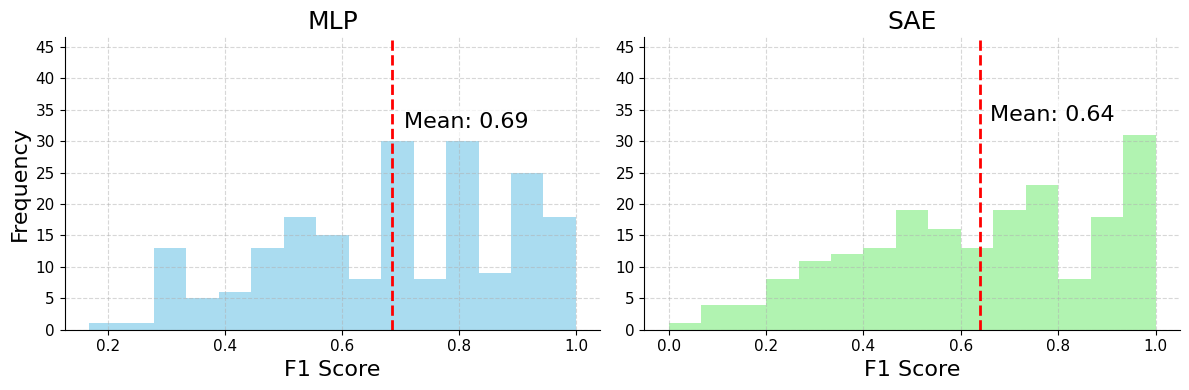

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Reset defaults
plt.rcdefaults()

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
BASE_FONT_SIZE = 16
DASHED_LINE_WIDTH = 2

# Load combined f1 scores mlp
combined_f1_scores_mlp = np.load('f1_scores_mlp.npy')
# Load combined f1 scores sae
combined_f1_scores_sae = np.load('f1_scores_sae.npy')

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Function to plot histogram and add mean label
def plot_histogram(ax, data, mean, color, title):
    n, bins, patches = ax.hist(data, bins=15, alpha=0.7, color=color)  # Removed edgecolor argument
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=DASHED_LINE_WIDTH)
    
    # Adjust the position of the mean label
    label_x = mean + 0.02  # Move label slightly to the right
    label_y = ax.get_ylim()[1] * 1.1  # Move label slightly down from the top
    
    ax.text(label_x, label_y, f'Mean: {mean:.2f}',
            horizontalalignment='left', verticalalignment='top', fontsize=BASE_FONT_SIZE,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    
    ax.set_title(title, fontsize=BASE_FONT_SIZE+2)
    ax.set_xlabel('F1 Score', fontsize=BASE_FONT_SIZE)
    ax.tick_params(labelsize=BASE_FONT_SIZE-5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

mean_f1_score_sae = np.mean(combined_f1_scores_sae)
std_f1_score_sae = np.std(combined_f1_scores_sae)
mean_f1_score_mlp = np.mean(combined_f1_scores_mlp)
std_f1_score_mlp = np.std(combined_f1_scores_mlp)

# Plot MLP histogram
plot_histogram(ax1, combined_f1_scores_mlp, mean_f1_score_mlp, 'skyblue', 'MLP')
ax1.set_ylabel('Frequency', fontsize=BASE_FONT_SIZE)

# Plot SAE histogram
plot_histogram(ax2, combined_f1_scores_sae, mean_f1_score_sae, 'lightgreen', 'SAE')

# Set the same y-axis range for both subfigures
max_count = max(
    max(np.histogram(combined_f1_scores_mlp, bins=15)[0]),
    max(np.histogram(combined_f1_scores_sae, bins=15)[0])
)
ax1.set_ylim(0, max_count * 1.5)
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.set_ylim(0, max_count * 1.5)
ax2.grid(True, linestyle='--', alpha=0.5)

# Use MaxNLocator to get integer tick locations on y-axis
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig("f1_score_distribution.pdf", bbox_inches='tight')

# Show the plot
plt.show()

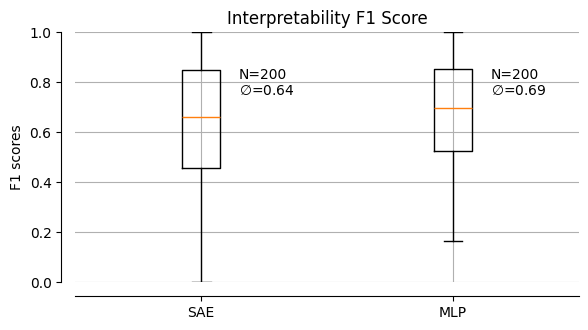

In [10]:
import seaborn as sns

sae = combined_f1_scores_sae
mlp = combined_f1_scores_mlp

# plt.figure(figsize=.45 * np.array((10, 5)))
# plt.boxplot([sae, mlp])
# plt.xticks([1, 2], ['SAE', 'MLP'])
# plt.title('Interpretability F1 Score')
# plt.ylabel('F1 scores')
# plt.text(1.15, .75, f'N={len(sae)}\n' + r'$\varnothing$=%.2f' % np.mean(sae))
# plt.text(2.15, .75, f'N={len(mlp)}\n' + r'$\varnothing$=%.2f' % np.mean(mlp))
# plt.ylim(0, 1)
# plt.grid()
# sns.despine(offset=10)
# plt.savefig('fig_wild.pdf')
# plt.show()

plt.figure(figsize=0.65 * np.array((10, 5)))  # Increased figure size slightly
plt.boxplot([sae, mlp])
plt.xticks([1, 2], ['SAE', 'MLP'])
plt.title('Interpretability F1 Score')
plt.ylabel('F1 scores')

# Adjust text positioning slightly to avoid overlapping
plt.text(1.15, .75, f'N={len(sae)}\n' + r'$\varnothing$=%.2f' % np.mean(sae))
plt.text(2.15, .75, f'N={len(mlp)}\n' + r'$\varnothing$=%.2f' % np.mean(mlp))

plt.ylim(0, 1)
plt.grid()
sns.despine(offset=10)

# Use bbox_inches='tight' to avoid cutting off parts
plt.savefig('fig_wild.pdf', bbox_inches='tight')
plt.show()
